# EcoPoints Data Analysis

In [1]:
import json
import pandas as pd
import pydeck as pdk
import plotly.express as px
import plotly.graph_objects as go

In [2]:
with open('data.json') as f:
    data = json.load(f)

In [3]:
timestamps = []
engine_load = []
engine_rpm = []
coolant_temp = []
altitude = []
gps_speed = []
vehicle_speed = []
armin_speed = []
latitude = []
longitude = []

In [4]:
for entry in data:
    timestamps.append(pd.to_datetime(entry.get('timestamp'), unit='ms'))
    
    entry_data = entry.get('data', {})
    engine_load.append(float(entry_data.get('Engine Load', '0').replace(',', '.')))
    engine_rpm.append(float(entry_data.get('Engine RPM', '0').replace(',', '.')))
    coolant_temp.append(float(entry_data.get('Engine Coolant Temperature', '0').replace(',', '.')))
    altitude.append(float(entry_data.get('Altitude', '0').replace(',', '.')))
    gps_speed.append(float(entry_data.get('Gps-Speed', '0').replace(',', '.')))
    vehicle_speed.append(float(entry_data.get('Vehicle Speed', '0').replace(',', '.')))
    armin_speed.append(float(entry_data.get('Armin-Speed', '0').replace(',', '.')))
    latitude.append(float(entry_data.get('Latitude', '0')))
    longitude.append(float(entry_data.get('Longitude', '0')))

In [5]:
df = pd.DataFrame({
    'timestamp': timestamps,
    'Engine Load': engine_load,
    'Engine RPM': engine_rpm,
    'Coolant Temperature': coolant_temp,
    'Altitude': altitude,
    'Gps Speed': gps_speed,
    'Vehicle Speed': vehicle_speed,
    'Armin Speed': armin_speed,
    'Latitude': latitude,
    'Longitude': longitude
})

In [10]:
df.dropna(axis=1, inplace=True)

In [6]:
df = df[:-1]  

In [13]:
df

,timestamp,Engine Load,Engine RPM,Coolant Temperature,Altitude,Gps Speed,Vehicle Speed,Armin Speed,Latitude,Longitude
0,2024-10-23 15:57:36.173,31.4,800.0,98.0,481.503018,0.0,0.0,0.0,48.355683,14.183365
1,2024-10-23 15:57:39.834,31.8,802.0,98.0,481.449684,0.0,0.0,0.0,48.355683,14.183365
2,2024-10-23 15:57:43.500,32.2,796.0,98.0,481.412342,0.0,0.0,0.0,48.355683,14.183365
3,2024-10-23 15:57:47.154,31.8,801.0,98.0,481.378159,0.0,0.0,0.0,48.355683,14.183365
4,2024-10-23 15:57:50.826,31.8,798.0,98.0,481.530453,0.0,0.0,0.0,48.355683,14.183365
5,2024-10-23 15:57:54.511,31.4,798.0,98.0,481.291622,0.0,0.0,0.0,48.355683,14.183365
6,2024-10-23 15:57:58.181,55.3,794.0,98.0,481.441774,7.0,0.0,0.0,48.355701,14.183381
7,2024-10-23 15:58:01.851,71.0,1177.0,98.0,481.827893,19.0,12.0,0.0,48.355753,14.183533
8,2024-10-23 15:58:05.527,73.3,1325.0,98.0,483.023760,38.0,23.0,0.0,48.355868,14.183895
9,2024-10-23 15:58:09.212,11.4,2667.0,98.0,484.314037,45.0,42.0,0.0,48.356068,14.184522


In [14]:
print(df.head())

                timestamp  Engine Load  Engine RPM  Coolant Temperature  \
0 2024-10-23 15:57:36.173         31.4       800.0                 98.0   
1 2024-10-23 15:57:39.834         31.8       802.0                 98.0   
2 2024-10-23 15:57:43.500         32.2       796.0                 98.0   
3 2024-10-23 15:57:47.154         31.8       801.0                 98.0   
4 2024-10-23 15:57:50.826         31.8       798.0                 98.0   

     Altitude  Gps Speed  Vehicle Speed  Armin Speed   Latitude  Longitude  
0  481.503018        0.0            0.0          0.0  48.355683  14.183365  
1  481.449684        0.0            0.0          0.0  48.355683  14.183365  
2  481.412342        0.0            0.0          0.0  48.355683  14.183365  
3  481.378159        0.0            0.0          0.0  48.355683  14.183365  
4  481.530453        0.0            0.0          0.0  48.355683  14.183365  


In [15]:
path_data = [
    {"path": [[row['Longitude'], row['Latitude']] for _, row in df.iterrows()]}  # Creating paths from all points
]

In [16]:
layer = pdk.Layer(
    "PathLayer",
    path_data,
    get_path='path',
    get_width=1,  # Thinner width for the path
    get_color='[0, 128, 255]',  # Color for the path (blue)
    width_scale=10,  # Scale the width based on some factor
    pickable=True,
)

In [17]:
view_state = pdk.ViewState(
    latitude=df['Latitude'].mean() if not df['Latitude'].empty else 0.0,  # Center the map around the mean latitude
    longitude=df['Longitude'].mean() if not df['Longitude'].empty else 0.0,  # Center the map around the mean longitude
    zoom=12,  # Set zoom level to focus on the route
    bearing=0,
    pitch=0,
)

In [18]:
deck = pdk.Deck(layers=[layer], initial_view_state=view_state)
deck.to_html("driven_route_map.html")

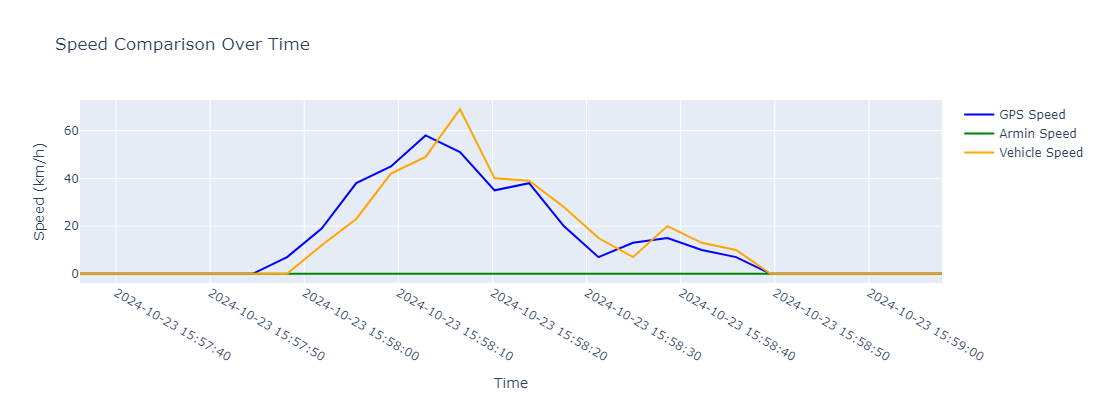

In [25]:
speedsFig = go.Figure()
speedsFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Gps Speed'], mode='lines', name='GPS Speed', line=dict(color='blue')))
speedsFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Armin Speed'], mode='lines', name='Armin Speed', line=dict(color='green')))
speedsFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Vehicle Speed'], mode='lines', name='Vehicle Speed', line=dict(color='orange')))
speedsFig.update_layout(title='Speed Comparison Over Time', xaxis_title='Time', yaxis_title='Speed (km/h)', xaxis=dict(tickformat='%Y-%m-%d %H:%M:%S'), width=800, height=400)
speedsFig.show()

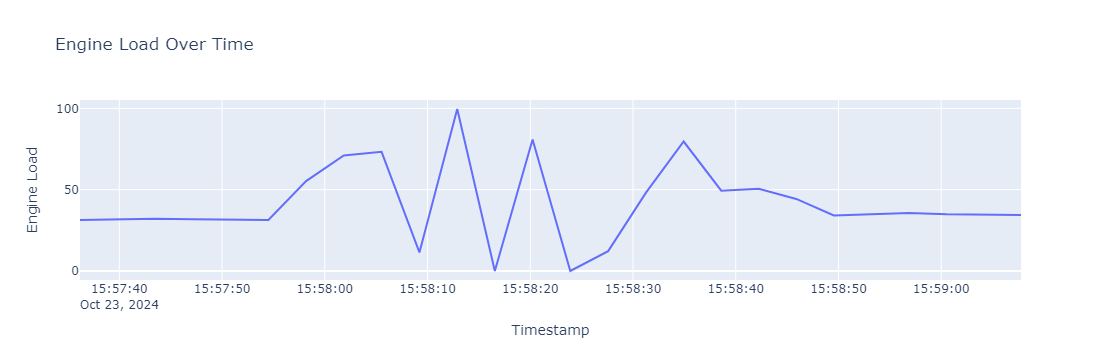

In [26]:
loadFig = go.Figure()
loadFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Engine Load'], mode='lines', name='Engine Load vs. Timestamp'))
loadFig.update_layout(title='Engine Load Over Time', xaxis_title='Timestamp', yaxis_title='Engine Load')
loadFig.show()

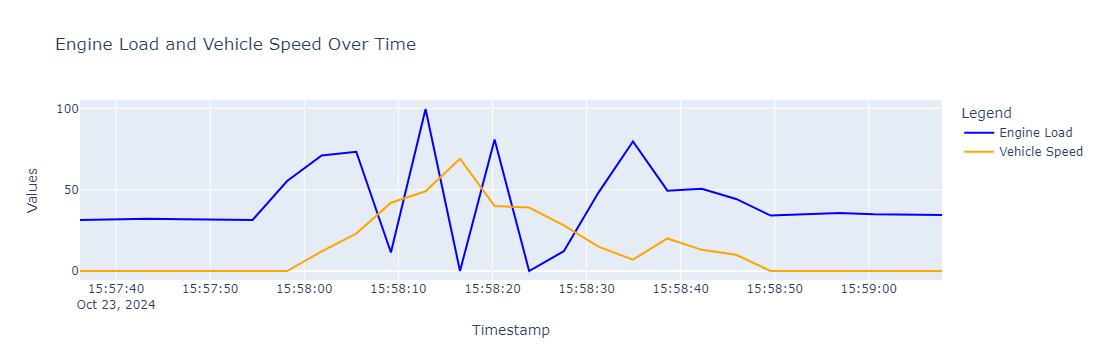

In [30]:
loadSpeedFig = go.Figure()
loadSpeedFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Engine Load'], mode='lines', name='Engine Load', line=dict(color='blue', width=2)))
loadSpeedFig.add_trace(go.Scatter(x=df['timestamp'], y=df['Vehicle Speed'], mode='lines', name='Vehicle Speed', line=dict(color='orange', width=2)))
loadSpeedFig.update_layout(
    title='Engine Load and Vehicle Speed Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Values',
    legend_title='Legend',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode='x unified'
)
loadSpeedFig.show()

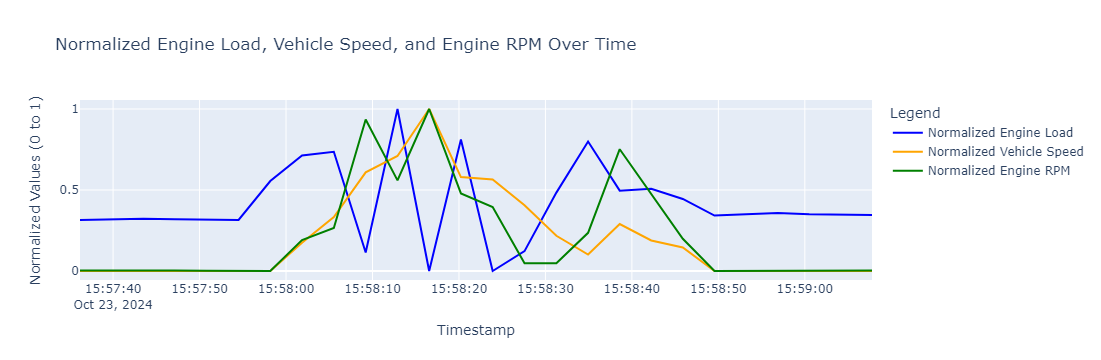

In [32]:
df['Normalized Engine Load'] = (df['Engine Load'] - df['Engine Load'].min()) / (df['Engine Load'].max() - df['Engine Load'].min())
df['Normalized Vehicle Speed'] = (df['Vehicle Speed'] - df['Vehicle Speed'].min()) / (df['Vehicle Speed'].max() - df['Vehicle Speed'].min())
df['Normalized Engine RPM'] = (df['Engine RPM'] - df['Engine RPM'].min()) / (df['Engine RPM'].max() - df['Engine RPM'].min())

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Normalized Engine Load'], mode='lines', name='Normalized Engine Load', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Normalized Vehicle Speed'], mode='lines', name='Normalized Vehicle Speed', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Normalized Engine RPM'], mode='lines', name='Normalized Engine RPM', line=dict(color='green', width=2)))
fig.update_layout(
    title='Normalized Engine Load, Vehicle Speed, and Engine RPM Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Normalized Values (0 to 1)',
    legend_title='Legend',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode='x unified'
)
fig.show()